In [1]:
import torch
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference.base import infer
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from scipy.stats import binom, gaussian_kde
import matplotlib as mpl
from logging import warn
from sbi.analysis.plot import pairplot, marginal_plot, _get_default_fig_kwargs

## Plotting functionality

Here we will have a look at the different options for creating pairplots and marginal plots, as well as how to finetune their look, (e.g. change the colormap used).


Lets first draw some samples from the posterior used in a tutorial 7


In [2]:
from toy_posterior_for_07_cc import ExamplePosterior

posterior = ExamplePosterior()
x_o = torch.ones(1, 20) 
posterior.set_default_x(x_o)
posterior_samples = posterior.sample((100,))


We will start with the default plot and gradually make it prettier

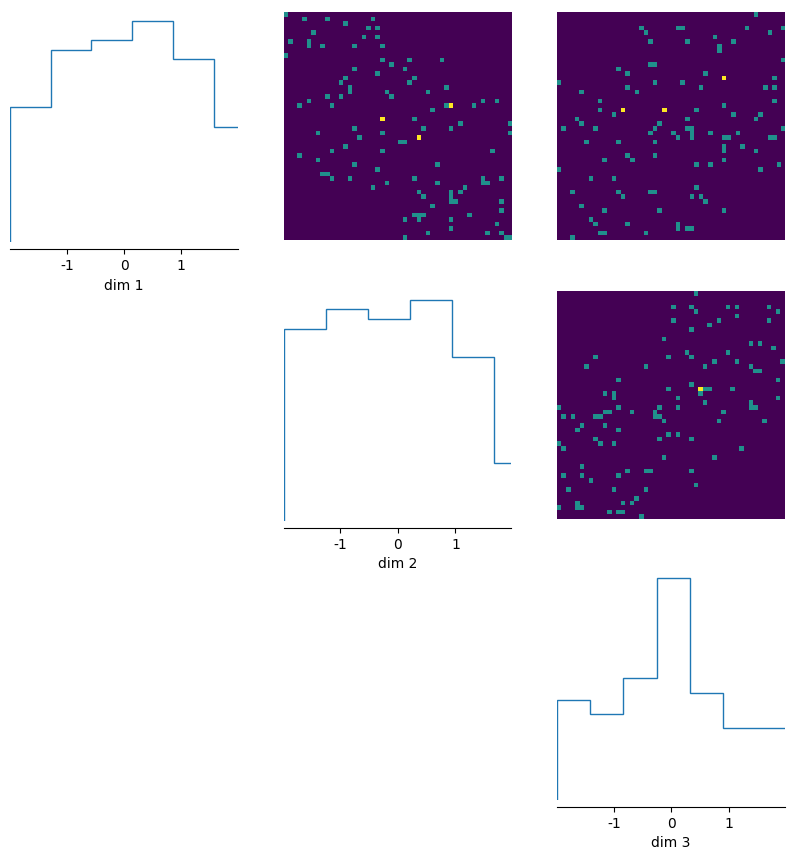

In [15]:
_ = pairplot(
    posterior_samples,
)

### Customisation

The pairplots are split into three regions, the diagonal and the upper and lower off-diagonal regions. We can pass seperate plottype argument (e.g. hist, kde, scatter) for each region, as well as corresponding keywords in a dictionary.

To get a closer look at the potential keywords, have a look at the _get_default_fig_kwargs, _get_default_diag_kwargs and _get_default_offdiag_kargs functions in analysis/plot.py

the diagonal and off-diagonal kwargs, can take a mpl_kwargs dictionary that includes keywords directly passed to the matplotlib plotting function currently used 
[e.g. for hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

Lets make a scatter plot for the upper diagonal, a histogram for the diagonal and pass keywords for each.

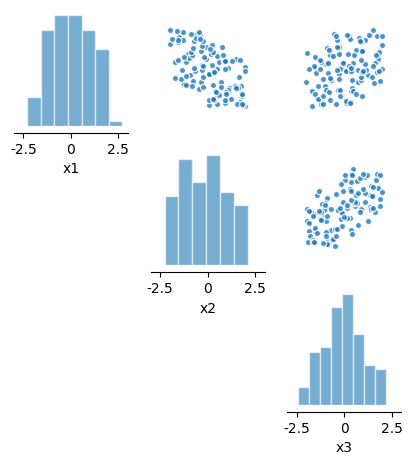

In [4]:

# plot posterior samples
_ = pairplot(
    posterior_samples, limits=[[-3,3]*3], figsize=(5, 5),
    diag="hist",
    upper="scatter",
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True},},
    upper_kwargs={"mpl_kwargs": {"color":'tab:blue',"s":20,"alpha":.8},},
    labels=["x1", "x2", "x3"],
)

By passing a list of samples and plotstyles, we can plot two sets of samples on top of each other

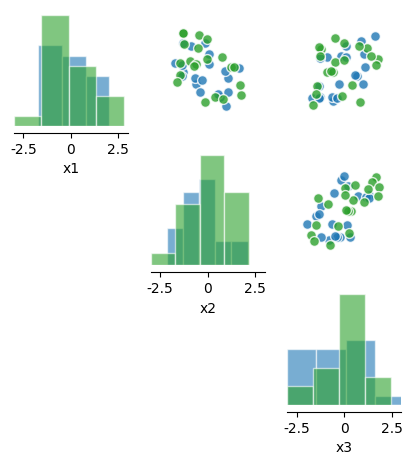

In [16]:
# plot posterior samples
posterior_samples1 = posterior.sample((20,))
posterior_samples2 = posterior.sample((20,))
_ = pairplot(
    [posterior_samples1,posterior_samples2], limits=[[-3,3]*3], figsize=(5, 5),
    diag=["hist","hist"],
    upper=["scatter","scatter"],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True},},
    upper_kwargs={"mpl_kwargs": {"s":50,"alpha":.8}},
    labels=["x1", "x2", "x3"],
 
    


)

We can use the same functionality to plot two different plot styles of the same set of samples on top of each other, e.g. a kernel-density estimate on top of scatter plot

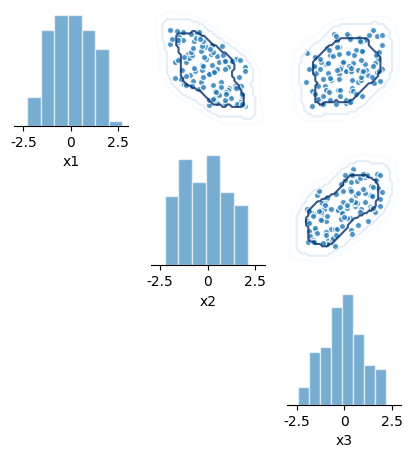

In [17]:

# plot posterior samples
_ = pairplot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3], figsize=(5, 5),
    diag=["hist",None],
    upper=["scatter","contour"],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True},},
    upper_kwargs=[{"mpl_kwargs": {"color":'tab:blue',"s":20,"alpha":.8},},
                  {"mpl_kwargs": {"cmap":'Blues_r',"alpha":.8,"colors":None}}],
    labels=["x1", "x2", "x3"],
            fig_kwargs={"despine":{"offset":0}}


)

We can add something in the lower off-diagonal as well

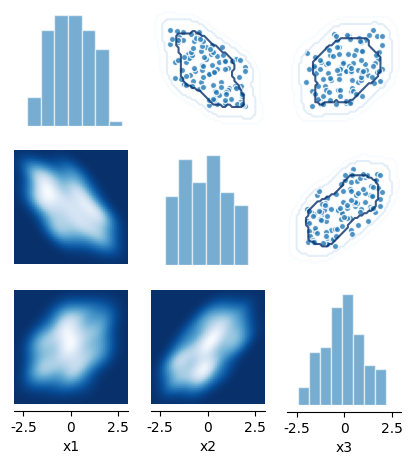

In [18]:

# plot posterior samples
_ = analysis.pairplot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3], figsize=(5, 5),
    diag=["hist",None],
    upper=["scatter","contour"],
    lower =["kde",None],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True},},
    upper_kwargs=[{"mpl_kwargs": {"color":'tab:blue',"s":20,"alpha":.8},},
                  {"mpl_kwargs": {"cmap":'Blues_r',"alpha":.8,"colors":None}}],
    lower_kwargs={"mpl_kwargs": {"cmap":"Blues_r"}},
    labels=["x1", "x2", "x3"],


)

We can also add points, e.g. our observed data x_o to the plot

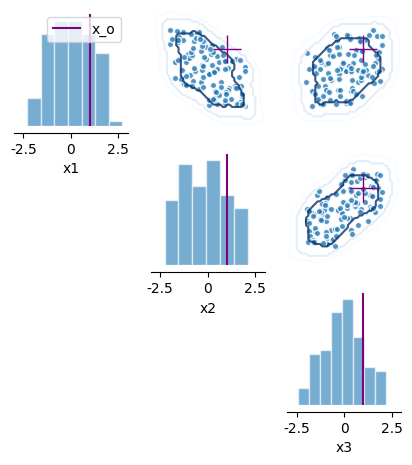

In [19]:
# plot posterior samples
_ = pairplot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3], figsize=(5, 5),
    diag=["hist",None],
    upper=["scatter","contour"],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True},},
    upper_kwargs=[{"mpl_kwargs": {"color":'tab:blue',"s":20,"alpha":.8},},
                  {"mpl_kwargs": {"cmap":'Blues_r',"alpha":.8,"colors":None}}],
    labels=["x1", "x2", "x3"],
    points = [torch.ones(1, 3)],
    fig_kwargs={"points_labels": ["x_o"],"legend":True,
            'points_colors':['purple'],
             'points_offdiag' : {'marker':"+", 'markersize':20}},

    


)

For high-dimensional posteriors, we might only want to visualise a subset, this can be done with the subset function

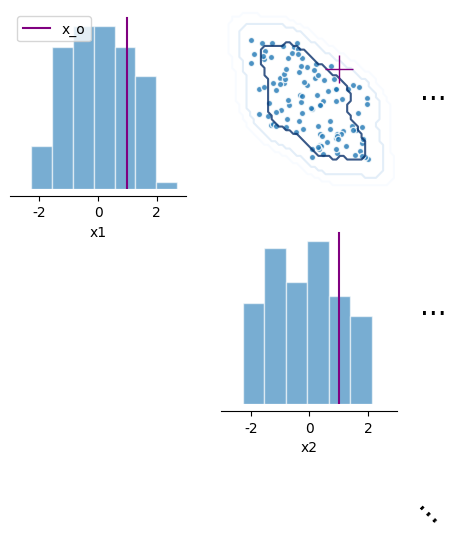

In [8]:
# plot posterior samples
_ = pairplot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3], figsize=(5, 5),
    subset=[0,1],
    diag=["hist",None],
    upper=["scatter","contour"],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True},},
    upper_kwargs=[{"mpl_kwargs": {"color":'tab:blue',"s":20,"alpha":.8},},
                  {"mpl_kwargs": {"cmap":'Blues_r',"alpha":.8,"colors":None}}],
    labels=["x1", "x2", "x3"],
    points = [torch.ones(1, 3)],
    fig_kwargs={"points_labels": ["x_o"],"legend":True,
            'points_colors':['purple'],
             'points_offdiag' : {'marker':"+", 'markersize':20}},

    


)

Marginals can be visualised using the marginal_plot functionality

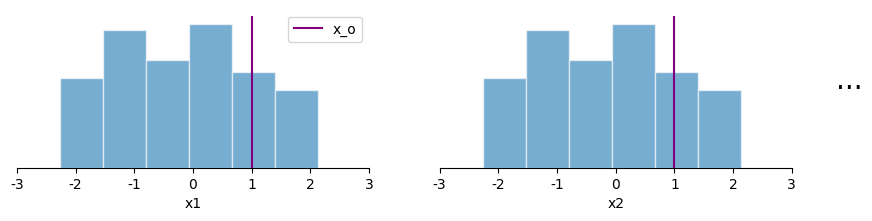

In [20]:
# plot posterior samples
_ = marginal_plot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3],
    subset=[0,1],
    diag=["hist",None],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True},},
    labels=["x1", "x2", "x3"],
    points = [torch.ones(1, 3)],
    fig_kwargs={"points_labels": ["x_o"],"legend":True,
            'points_colors':['purple'],
             'points_offdiag' : {'marker':"+", 'markersize':20},
             "despine":{"offset":0}},

    


)